# Quantum topological analysis of stock market data

This notebook presents how persistent homology algorithm can be used to study stock market crashes based on past prices information.

### Load libraries

In [40]:
# reload modules before executing user code
%load_ext autoreload
# reload all modules every time before executing the Python code
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import yfinance as yf

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from graphs_plotting import plot_diagram, plot_point_cloud, plot_crash_detections, plot_crash_comparisons
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(color_codes=True, rc={'figure.figsize':(12, 4)})
sns.set_palette(sns.color_palette('muted'))


import gtda.time_series as ts
import gtda.diagrams as diag
import gtda.homology as hl
import gtda.graphs as gr
from gtda.pipeline import Pipeline

### Load and explore data

The data used for analysis are the historical weekly data on **The S&P 500 Industrial Average** from 1927 up to present days (Jun 13, 2020).
    
Here the `yfinance` library is used to download historical market data from Yahoo! Finance.

In [42]:
SP500 = yf.Ticker("^GSPC")
sp500_df = SP500.history(period="max", frequency="weekly")
sp500_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-06-08,3199.92,3233.13,3196.00,3232.39,8437380000,0,0
2020-06-09,3213.32,3222.71,3193.11,3207.18,6382620000,0,0
2020-06-10,3213.42,3223.27,3181.49,3190.14,6570840000,0,0
2020-06-11,3123.53,3123.53,2999.49,3002.10,7018890000,0,0
2020-06-12,3071.04,3088.42,2984.47,3041.31,5832250000,0,0


It is a common practice to focus on the `Close` price values, so we plot at the complete time series for `Close` values:

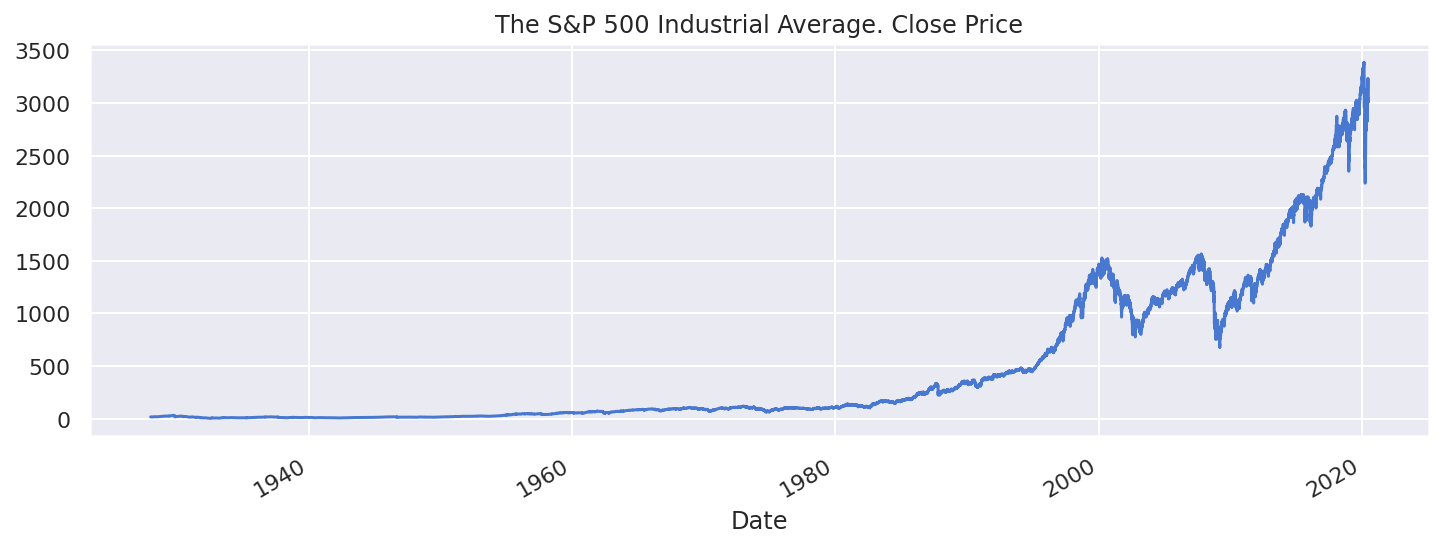

In [43]:
price_df = sp500_df['Close']
price_df.plot()
plt.title('The S&P 500 Industrial Average. Close Price')
plt.show()

With this plot one can clearly observe some huge stock market crashes that happened in 2004 as well as 2008 and right now in 2020.

### Resampling data

Since 100 years is quite big amount of time it would be more convenient to focus on shorter period of time - from 1980 until present days.

In [44]:
start_year = '1980'

# use pad to replace missing values by last non-missing value
resampled_prices = price_df.resample('7D').pad()[start_year:]

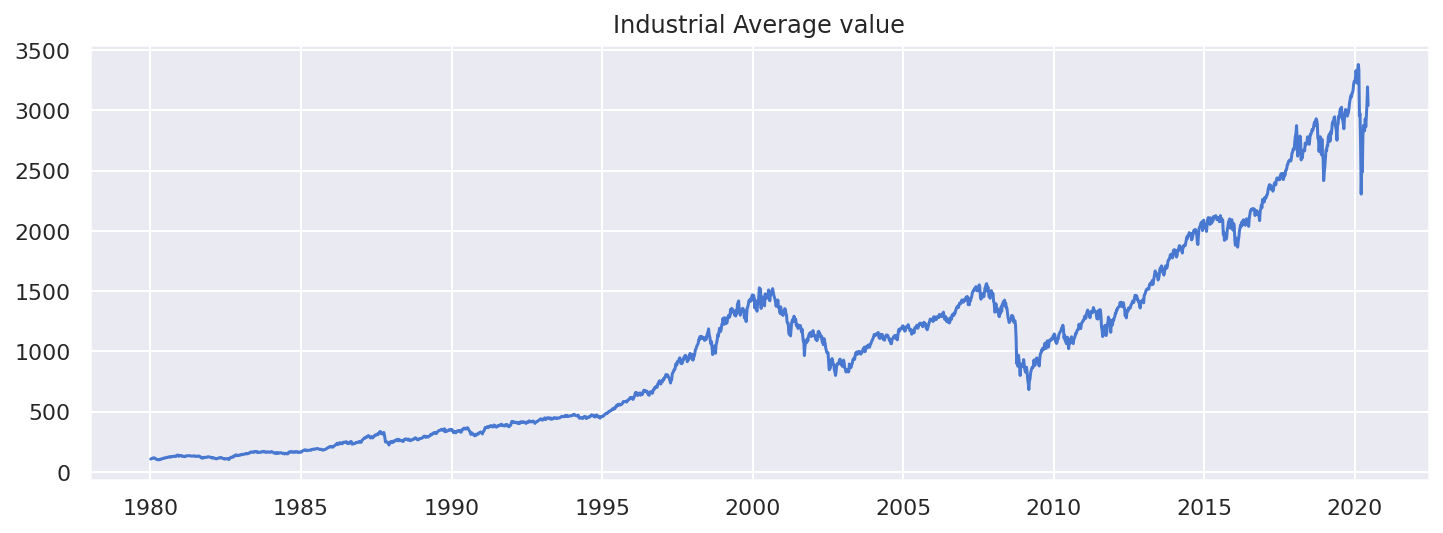

In [45]:
plt.plot(resampled_prices)
plt.title('Industrial Average value')
plt.show()

### Time series data to point clouds

It is common practice to observe time series as scatter plots in two dimensions. This way one can easily explore **local** behaviour of the series but it is usually ineffective when one needs to make observations that are affected during larger period of time.

Here, to construct the point clouds system the **Taken's embedding** algorithm is used.

The procedure works as follows: one needs to pick two integers $d$ and $\tau$. For each time $t_i \in (t_0, t_1, \ldots )$, the values of the variable $y$ at $d$ distinct times are collected, evenly spaced by $\tau$ and starting at $t_i$, and presented as a vector with $d$ entries, namely $Y_{t_i} = (y_{t_i}, y_{t_i + \tau}, \ldots , y_{t_i + (d-1)\tau})$. The result is a set of vectors in $d$-dimensional space! $\tau$ is called the **time delay** parameter, and $d$ the **embedding dimension**.

Applying the **sliding window** then allows one to apply Takens embedding locally on a certain interval rather than over the whole time series. The result of this procedure is therefore a time series of point clouds with possibly interesting topologies.

In [46]:
embedding_dimension = 3
embedding_time_delay = 2

Next one needs to initialise the embedder to represent the price time series as a time series of point clouds:

In [47]:
embedder = ts.TakensEmbedding(
    parameters_type="fixed",
    dimension=embedding_dimension,
    time_delay=embedding_time_delay,
    n_jobs=-1,
)

Now that the embedder is initialised, it is a simple matter to obtain an array of embeddings, where each element is a 3-dimensional vector:

In [48]:
price_values = resampled_prices.values
price_embedded = embedder.fit_transform(price_values)

embedder_time_delay = embedder.time_delay_
embedder_dimension = embedder.dimension_

Next we apply a sliding window to obtain the point clouds per window. We choose the window size such that each interval will span a period of 36 days:

In [49]:
window_width = 30
window_stride = 4

In [50]:
sliding_window = ts.SlidingWindow(width=window_width, stride=window_stride)
price_embedded_windows = sliding_window.fit_transform(price_embedded)

Now that the point clouds are created, let's visualise one of them:

In [51]:
window_num = 42
point_cloud = price_embedded_windows[window_num][:, :3]
plot_point_cloud(point_cloud)

### Persistence diagram

The first step in a TDA pipeline usually involves calculating persistence diagrams, which encode topological information on the dynamics in the embedding space. The horizontal axis corresponds to the moment in which a homological generator is born, while the vertical axis corresponds to the moments in which an homological generator dies.

In [52]:
# 1-d homology
homology_dimensions = (0, 1)
VR = hl.VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=1)
diagrams = VR.fit_transform(price_embedded_windows)

In the plot below for a single window, the generators of each homology dimension $H_0$ and $H_1$ are coloured differently:

In [53]:
plot_diagram(diagrams[window_num])

### Homological derivative

Given a persistence diagram, there are a number of possible features that can derived from it. For this algorithm, we are interested in calculating the distance between diagrams obtained from two successive windows.

In [54]:
"""
Source:
https://github.com/giotto-ai/stock-market-crashes
"""

from joblib import Parallel, delayed, effective_n_jobs

from sklearn.utils import gen_even_slices
from sklearn.utils.validation import check_is_fitted

from gtda.diagrams import PairwiseDistance
from gtda.diagrams._metrics import _parallel_pairwise, landscapes, betti_curves
from gtda.diagrams._utils import _subdiagrams
from gtda.utils.validation import (
    check_diagrams,
    validate_params
)


class HomologicalDerivative(PairwiseDistance):
    def __init__(self, **kw_args):
        super().__init__(**kw_args)

    def _derivatives_generic(self, X, s):
        return np.array(
            [
                _parallel_pairwise(
                    np.expand_dims(X[t + 1], axis=0),
                    np.expand_dims(X[t], axis=0),
                    self.metric,
                    self.effective_metric_params_,
                    self.homology_dimensions_,
                    self.n_jobs,
                )[0, 0]
                for t in range(s.start, s.stop, 1)
            ]
        )

    def _derivatives(self, subdiagrams, kind, dim, params):
        n_samples, n_points = subdiagrams.shape[:2]
        if kind == "landscape":
            n_layers = min(params["n_layers"], n_points)
            features = landscapes(subdiagrams, params["samplings"][dim], n_layers)
        elif kind == "betti":
            features = betti_curves(subdiagrams, params["samplings"][dim])
        features = (features[1:] - features[:-1]).reshape(n_samples - 1, -1)
        features = np.linalg.norm(features, axis=1, ord=params["p"])
        return (params["step_sizes"][dim] ** (1 / params["p"])) * features

    def fit(self, X, y=None):
        super().fit(X, y)
        return self

    def transform(self, X, y=None):
        check_is_fitted(self, ["effective_metric_params_", "homology_dimensions_"])
        X = check_diagrams(X)

        if self.metric in ["landscape", "betti"]:
            Xt = Parallel(n_jobs=self.n_jobs)(
                delayed(self._derivatives)(
                    _subdiagrams(X[s.start : s.stop + 1], [dim], remove_dim=True),
                    self.metric,
                    dim,
                    self.effective_metric_params_,
                )
                for dim in self.homology_dimensions_
                for s in gen_even_slices(len(X) - 1, effective_n_jobs(self.n_jobs))
            )
            Xt = (
                np.concatenate(Xt).reshape(len(self.homology_dimensions_), len(X) - 1).T
            )
        else:
            Xt = Parallel(n_jobs=self.n_jobs)(
                delayed(self._derivatives_generic)(X, s)
                for s in gen_even_slices(len(X) - 1, effective_n_jobs(self.n_jobs))
            )
            Xt = np.concatenate(Xt)

        if self.order is not None:
            Xt = np.linalg.norm(Xt, axis=1, ord=self.order)

        return Xt

### Distances among diagrams using Betti curves

Next step is to compute the distances among persistence diagrams. There are many notions but **Betti curves** is used here as this one is the most convenient for later quantisation.

In [57]:
metric_params = {"p": 2, "n_bins": 100}

window_width_price = window_width + embedder_dimension * embedder_time_delay - 2
sliding_window_price = ts.SlidingWindow(width=window_width_price, stride=window_stride)
window_indices = sliding_window_price._slice_windows(price_values)

indices = [win[1] - 1 for win in window_indices[1:]]
time_index_derivs = resampled_prices.iloc[indices].index

In [60]:
resampled_close_price_derivs = resampled_prices.loc[time_index_derivs]

In [61]:
bettiHomDer = HomologicalDerivative(metric='betti',
                                    metric_params=metric_params,
                                    order=2, n_jobs=1)
betti_succ_dists = bettiHomDer.fit_transform(diagrams)

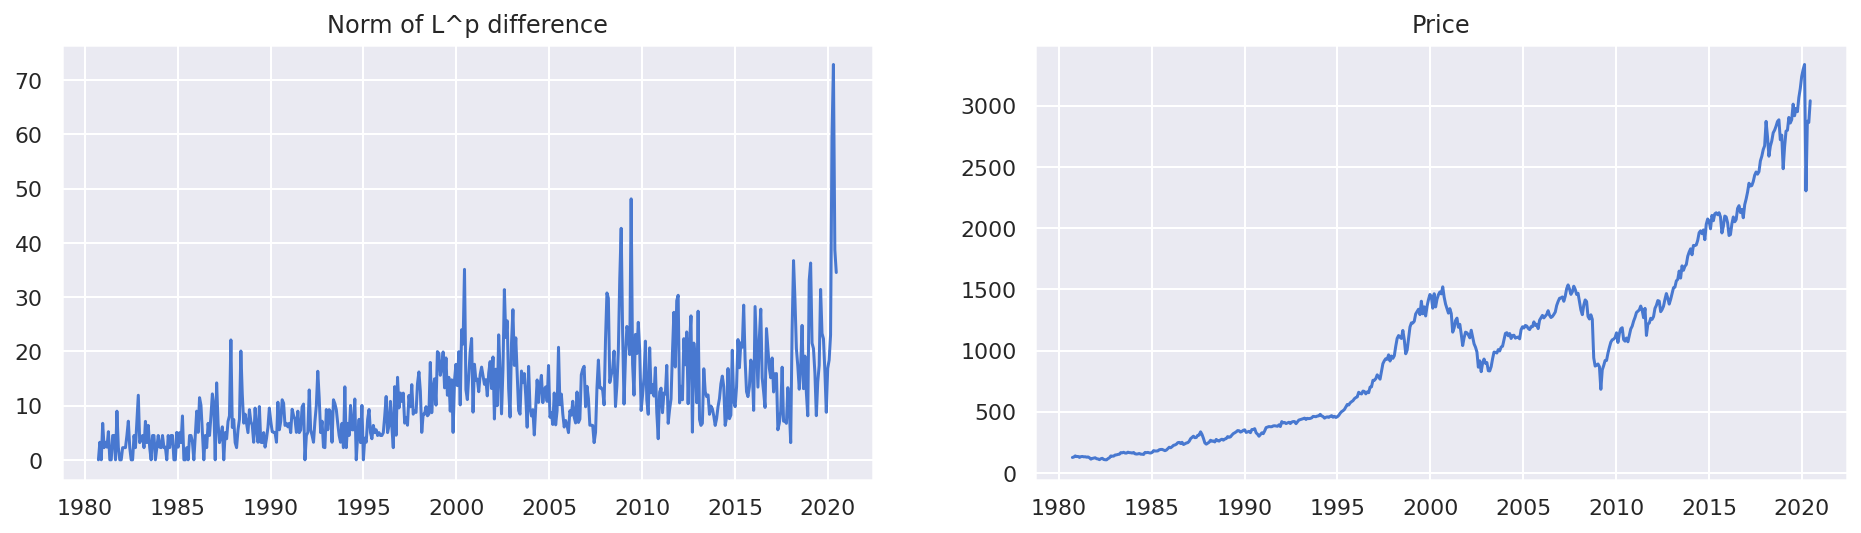

In [67]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(time_index_derivs, betti_succ_dists)
plt.title('Norm of L^p difference')

plt.subplot(1, 2, 2)
plt.plot(resampled_close_price_derivs)
plt.title('Price')
plt.show()

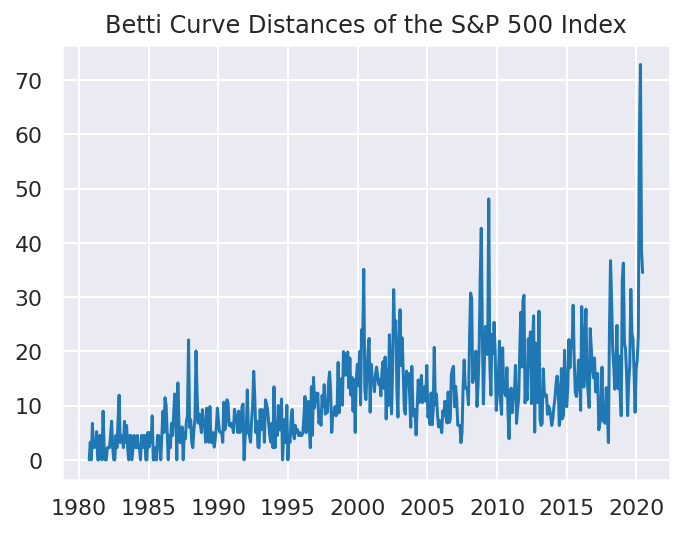

In [68]:
plt.subplot(1, 2, 2)
plt.plot(time_index_derivs, betti_succ_dists, "#1f77b4")
plt.title('Betti Curve Distances of the S&P 500 Index')
plt.show()

### Topological indicator for crashes

Let's investigate the last two major market crashes.

* **Subprime mortgage crisis:**  from  December 2007 – June 2009

* **2020 Corona crash:** from Februry 2020


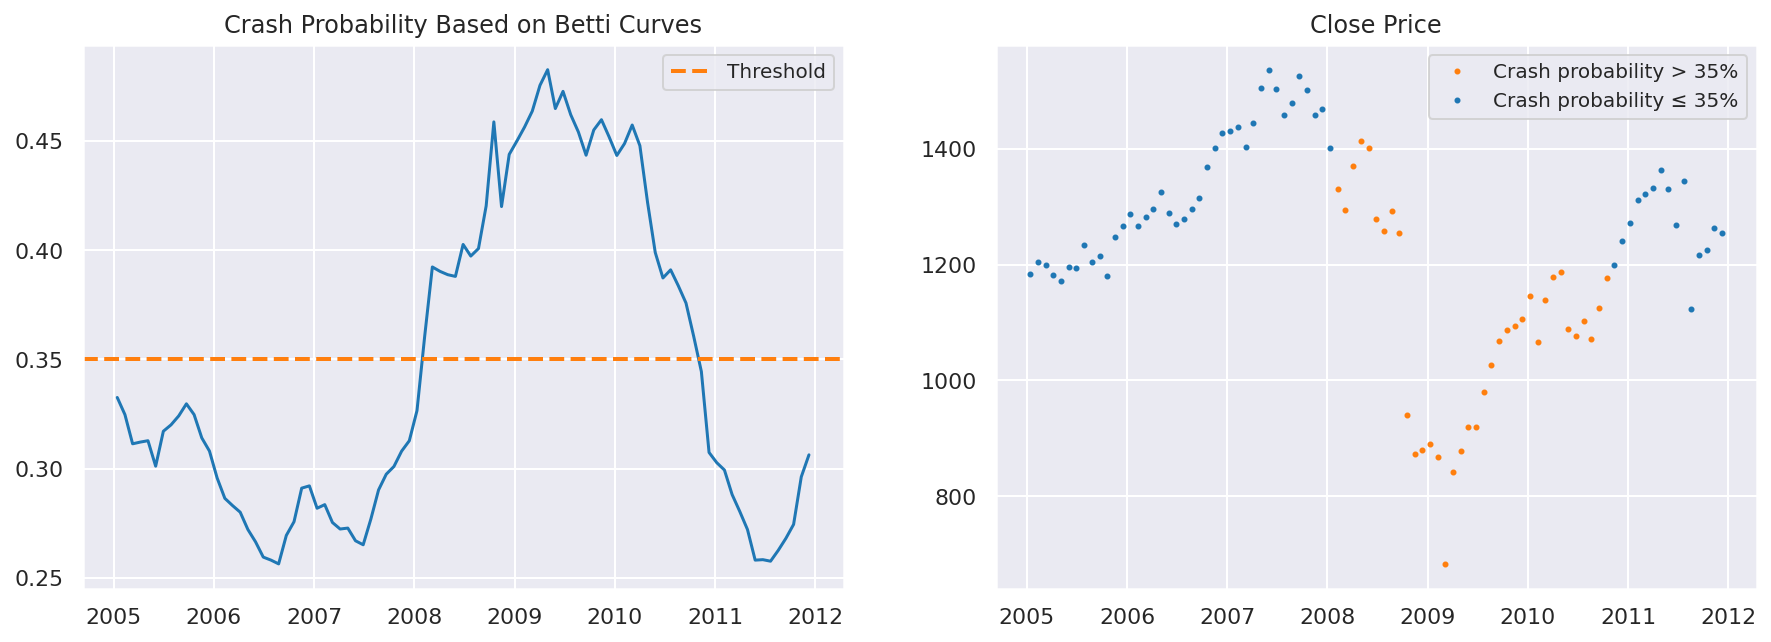

In [86]:
plot_crash_detections(
    start_date="2005-01-01",
    end_date="2012-01-01",
    threshold=0.35,
    distances=betti_succ_dists,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_close_price_derivs,
    metric_name='Betti Curves'
)

Here one can see that the homological derivative has captured part of the region where the market was crashing.

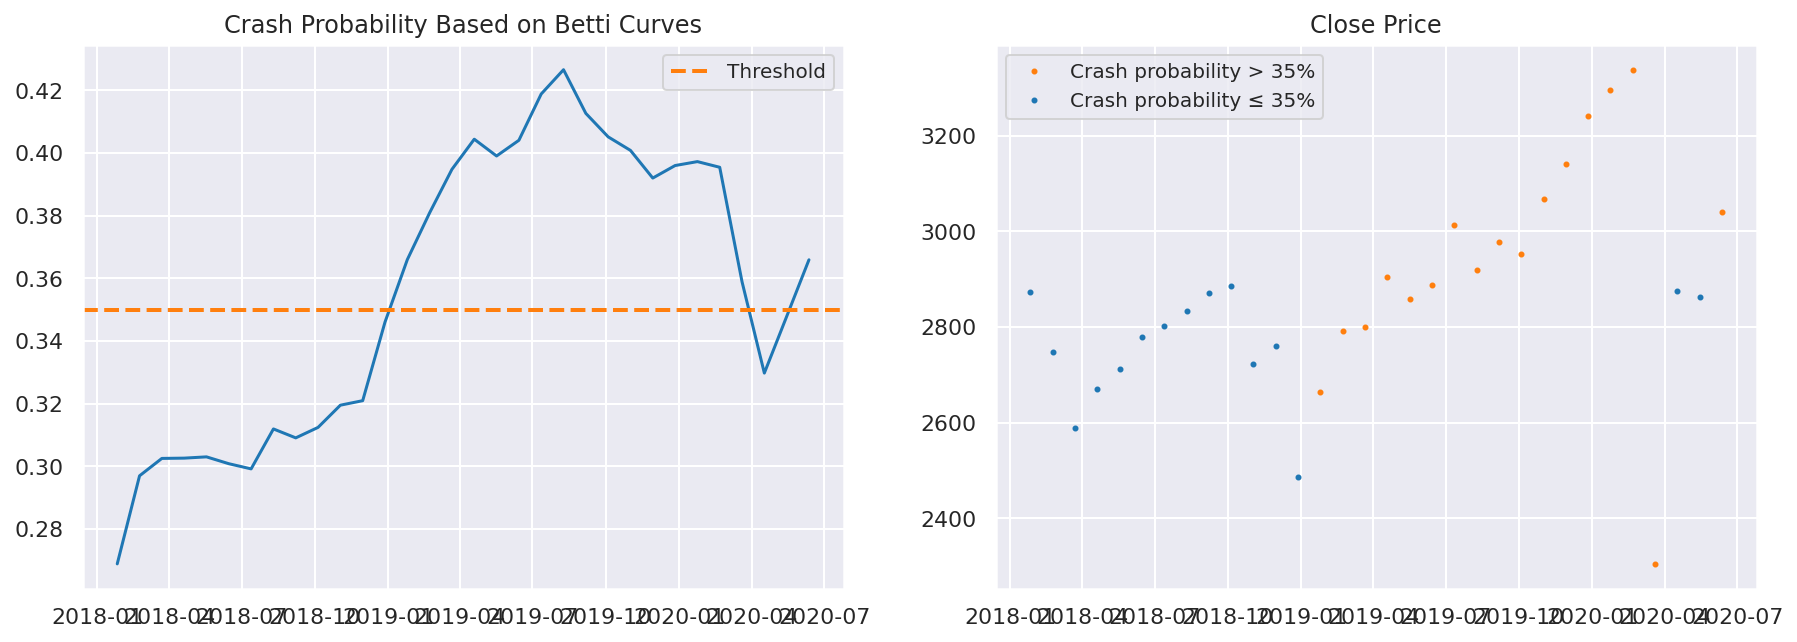

In [90]:
plot_crash_detections(
    start_date="2018-01-01",
    end_date="2020-06-13",
    threshold=0.35,
    distances=betti_succ_dists,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_close_price_derivs,
    metric_name='Betti Curves'
)

This figre can show one that for past year the stock market was, so to say, heating up and that the market crash of 2020 was **inevitable** and thus coronavirus pandemic only fastened the process.

### Conclusions

Peristent homology proves itself as a powerful tool for stock data analysis, however such topological indicator as **Betti numbers** prodices quite noisy results and tus is very sencitive to the choice of threshold value.
There are many other methods that are described in the project references, still this one remains the best choice for quantum algorithm implementation.